🔹 Step 1: Setup & Imports

In [53]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, f1_score

# Deep learning
import tensorflow as tf
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense, Dropout, GRU # type: ignore

# Ignore warnings for cleaner output
import warnings
warnings.filterwarnings("ignore")

🔹 Step 2: Load & Explore C-MAPSS (FD001) Dataset

In [54]:
# Path to C-MAPSS dataset (upload to Colab or mount from Google Drive)
train_path = "C:/Users/T8554/Desktop/Datasets/train_FD001.txt"
test_path = "C:/Users/T8554/Desktop/Datasets/test_FD001.txt"
rul_path = "C:/Users/T8554/Desktop/Datasets/RUL_FD001.txt"

# Load data
col_names = ["unit", "cycle", "os1", "os2", "os3"] + [f"s{i}" for i in range(1, 22)]
train_df = pd.read_csv(train_path, sep=" ", header=None)
train_df = train_df.drop([26,27], axis=1)  # drop empty columns
train_df.columns = col_names

test_df = pd.read_csv(test_path, sep=" ", header=None)
test_df = test_df.drop([26,27], axis=1)
test_df.columns = col_names

rul_df = pd.read_csv(rul_path, sep=" ", header=None)

In [55]:
print(train_df.head())
print(train_df.shape)

   unit  cycle     os1     os2    os3      s1      s2       s3       s4  \
0     1      1 -0.0007 -0.0004  100.0  518.67  641.82  1589.70  1400.60   
1     1      2  0.0019 -0.0003  100.0  518.67  642.15  1591.82  1403.14   
2     1      3 -0.0043  0.0003  100.0  518.67  642.35  1587.99  1404.20   
3     1      4  0.0007  0.0000  100.0  518.67  642.35  1582.79  1401.87   
4     1      5 -0.0019 -0.0002  100.0  518.67  642.37  1582.85  1406.22   

      s5  ...     s12      s13      s14     s15   s16  s17   s18    s19  \
0  14.62  ...  521.66  2388.02  8138.62  8.4195  0.03  392  2388  100.0   
1  14.62  ...  522.28  2388.07  8131.49  8.4318  0.03  392  2388  100.0   
2  14.62  ...  522.42  2388.03  8133.23  8.4178  0.03  390  2388  100.0   
3  14.62  ...  522.86  2388.08  8133.83  8.3682  0.03  392  2388  100.0   
4  14.62  ...  522.19  2388.04  8133.80  8.4294  0.03  393  2388  100.0   

     s20      s21  
0  39.06  23.4190  
1  39.00  23.4236  
2  38.95  23.3442  
3  38.88  23.3739 

🔹 Step 3: Preprocess C-MAPSS Data

In [56]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Compute RUL for training set
rul_train = train_df.groupby("unit")["cycle"].max().reset_index()
rul_train.columns = ["unit", "max_cycle"]

train_df = train_df.merge(rul_train, on="unit", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["cycle"]

# Normalize sensor data
scaler = MinMaxScaler()
sensor_cols = [f"s{i}" for i in range(1, 22)]
train_df[sensor_cols] = scaler.fit_transform(train_df[sensor_cols])

joblib.dump(scaler, "scaler_fd001.pkl")  # Save scaler for future use

print(train_df[["unit", "cycle", "RUL"]].head())

   unit  cycle  RUL
0     1      1  191
1     1      2  190
2     1      3  189
3     1      4  188
4     1      5  187


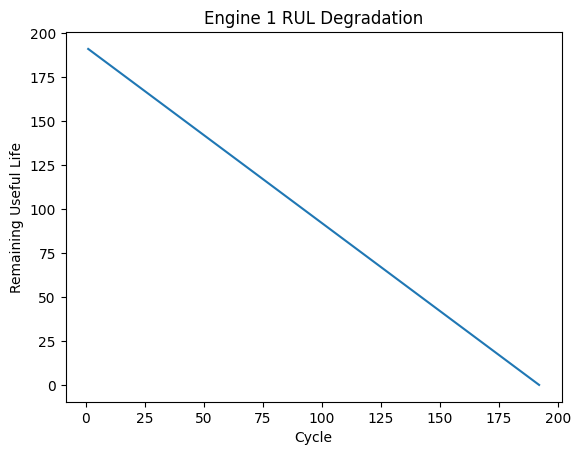

In [57]:
engine1 = train_df[train_df["unit"]==1]
plt.plot(engine1["cycle"], engine1["RUL"])
plt.xlabel("Cycle")
plt.ylabel("Remaining Useful Life")
plt.title("Engine 1 RUL Degradation")
plt.show()

🔹 Step 4: Load & Explore XJTU-SY Bearing Dataset

In [58]:
import numpy as np
import pandas as pd
import os

# Example: load one training pair (x = signals, y = labels)
x_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/xtr1_1.npy"
y_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/ytr1_1.npy"

X = np.load(x_file)   # shape: (samples, time, channels)
y = np.load(y_file)   # shape: (samples, 1)

print("X shape:", X.shape)
print("y shape:", y.shape)

# --- Feature Extraction (basic statistics from vibration signals) ---
# RMS = Root Mean Square per sample
rms = np.sqrt(np.mean(X**2, axis=(1, 2)))

# Mean amplitude
mean_val = np.mean(X, axis=(1, 2))

# Standard deviation
std_val = np.std(X, axis=(1, 2))

# Build DataFrame
features_df = pd.DataFrame({
    "rms": rms,
    "mean": mean_val,
    "std": std_val,
    "RUL": y.flatten()
})

print(features_df.head())

X shape: (123, 32768, 2)
y shape: (123, 1)
        rms      mean       std         RUL
0  0.319333  0.000215  0.319333  100.000000
1  0.326691 -0.002130  0.326684   99.180328
2  0.327543  0.002202  0.327536   98.360656
3  0.329079  0.003865  0.329057   97.540984
4  0.335730 -0.002841  0.335718   96.721311


In [59]:
# data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"

# features_all = []

# for file in os.listdir(data_dir):
#     if file.startswith("xtr"):   # training files only
#         x_file = os.path.join(data_dir, file)
#         y_file = os.path.join(data_dir, "y" + file[1:])  # replace 'x' with 'y'

#         X = np.load(x_file)
#         y = np.load(y_file)

#         rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
#         mean_val = np.mean(X, axis=(1, 2))
#         std_val = np.std(X, axis=(1, 2))

#         df = pd.DataFrame({
#             "rms": rms,
#             "mean": mean_val,
#             "std": std_val,
#             "RUL": y.flatten()
#         })
#         features_all.append(df)
# # Final combined dataset
# final_df = pd.concat(features_all, ignore_index=True)
# print(final_df.head())
# print(final_df.shape)

🔹 Step 5: Feature Extraction + Dataset Assembly (XJTU-SY)

Final dataset shape: (9214, 7)
  unit_id       rms      mean       std       max       min         RUL
0     1_1  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000
1     1_1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328
2     1_1  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656
3     1_1  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984
4     1_1  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311
Random Forest RUL Prediction RMSE: 1.1197295307204005
Random Forest Health Stage Accuracy: 1.0
Random Forest Health Stage F1-score: 1.0

Classification Report:

              precision    recall  f1-score   support

     Failure       1.00      1.00      1.00       730
     Healthy       1.00      1.00      1.00       730
     Warning       1.00      1.00      1.00       964

    accuracy                           1.00      2424
   macro avg       1.00      1.00      1.00      2424
weighted avg       1.00      1.00      1.00      2

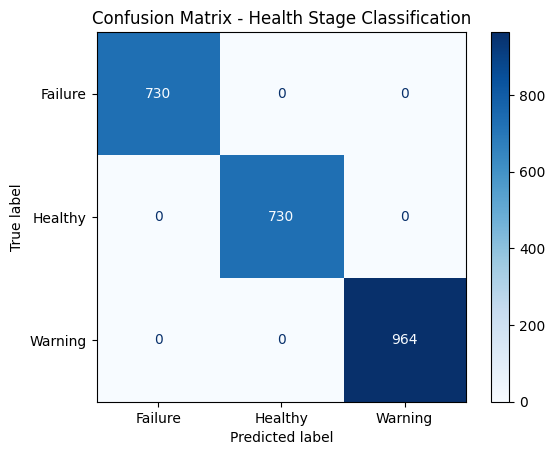

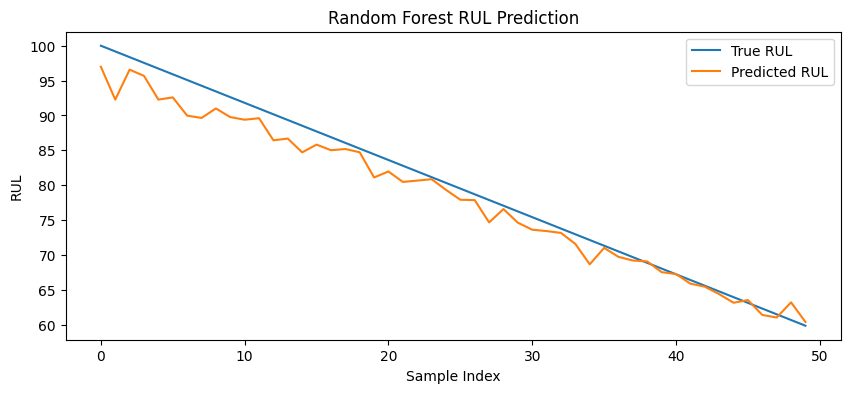

In [60]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt

# Path to dataset
data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"

features_all = []

# Loop through training files
for file in os.listdir(data_dir):
    if file.startswith("xtr"):   # training files only
        x_file = os.path.join(data_dir, file)
        y_file = os.path.join(data_dir, "y" + file[1:])  # replace 'x' with 'y'

        unit_id = file.replace("xtr", "").replace(".npy", "")

        if not os.path.exists(y_file):
            continue  # skip if no matching y file

        X = np.load(x_file)   # shape (samples, time, channels)
        y = np.load(y_file)   # shape (samples, 1)

        # --- Feature Extraction ---
        rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
        mean_val = np.mean(X, axis=(1, 2))
        std_val = np.std(X, axis=(1, 2))
        max_val = np.max(X, axis=(1, 2))
        min_val = np.min(X, axis=(1, 2))

        df = pd.DataFrame({
            "unit_id": unit_id,
            "rms": rms,
            "mean": mean_val,
            "std": std_val,
            "max": max_val,
            "min": min_val,
            "RUL": y.flatten()
        })
        features_all.append(df)

# Final combined dataset
final_df = pd.concat(features_all, ignore_index=True)
print("Final dataset shape:", final_df.shape)
print(final_df.head())

# --- Define Health Stages from RUL ---
final_df["health_stage"] = pd.cut(
    final_df["RUL"],
    bins=[-0.1, 30, 70, final_df["RUL"].max()],
    labels=["Failure", "Warning", "Healthy"],
    include_lowest=True
)

# --- Features & Labels ---
X_features = final_df[["rms", "mean", "std", "max", "min"]]
y_rul = final_df["RUL"]                     # Regression target (Remaining Useful Life)
y_health = final_df["health_stage"]         # Classification target

# --- Train-Test Split (single split for both tasks) ---
# X_train, X_test, y_train_rul, y_test_rul, y_train_cls, y_test_cls = train_test_split(
#     X_features, y_rul, y_health, test_size=0.2, random_state=42
# )

units = final_df["unit_id"].unique()
np.random.seed(42)
np.random.shuffle(units)
train_units = units[:int(0.8*len(units))]
test_units  = units[int(0.8*len(units)):]

X_train = final_df[final_df.unit_id.isin(train_units)][["rms","mean","std","max","min"]].values
y_train_cls = final_df[final_df.unit_id.isin(train_units)]["health_stage"].values
y_train_rul = final_df[final_df.unit_id.isin(train_units)]["RUL"].values

X_test = final_df[final_df.unit_id.isin(test_units)][["rms","mean","std","max","min"]].values
y_test_cls = final_df[final_df.unit_id.isin(test_units)]["health_stage"].values
y_test_rul = final_df[final_df.unit_id.isin(test_units)]["RUL"].values

# --- Baseline 1: Random Forest for RUL (Regression) ---
rf_reg = RandomForestRegressor(n_estimators=100, random_state=42)
rf_reg.fit(X_train, y_train_rul)
y_pred_rul = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul))
print("Random Forest RUL Prediction RMSE:", rmse)

# --- Baseline 2: Random Forest for Health Stage (Classification) ---
rf_cls = RandomForestClassifier(n_estimators=100, random_state=42)
rf_cls.fit(X_train, y_train_cls)
y_pred_cls = rf_cls.predict(X_test)

acc = accuracy_score(y_test_cls, y_pred_cls)
f1 = f1_score(y_test_cls, y_pred_cls, average="weighted")
print("Random Forest Health Stage Accuracy:", acc)
print("Random Forest Health Stage F1-score:", f1)

# --- Classification Report ---
print("\nClassification Report:\n")
print(classification_report(y_test_cls, y_pred_cls))

# --- Confusion Matrix ---
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Stage Classification")
plt.show()

# --- Visualization of RUL Predictions ---
plt.figure(figsize=(10, 4))
plt.plot(y_test_rul[:50], label="True RUL")
plt.plot(y_pred_rul[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction")
plt.show()

🔹 Step 6: Preprocess FD001 (save CSV)

In [61]:
# import numpy as np
# import pandas as pd

# # ------------------------------
# # Paths (update as per your folder)
# # ------------------------------
# train_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/train_FD001.txt"
# test_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt"
# rul_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

# # ------------------------------
# # Column Names
# # ------------------------------
# col_names = [
#     "unit_number", "time_in_cycles",
#     "operational_setting_1", "operational_setting_2", "operational_setting_3"
# ] + [f"sensor_{i}" for i in range(1, 22)]  # 21 sensors

# # # ------------------------------
# # # Load Training Data
# # # ------------------------------
# # train_df = pd.read_csv(train_file, delim_whitespace=True, header=None)
# # train_df.columns = col_names

# # # Create RUL (max cycle - current cycle)
# # rul_df = train_df.groupby("unit_number")["time_in_cycles"].max().reset_index()
# # rul_df.columns = ["unit_number", "max_cycle"]

# # train_df = train_df.merge(rul_df, on="unit_number", how="left")
# # train_df["RUL"] = train_df["max_cycle"] - train_df["time_in_cycles"]/


# # sensor column list
# sensor_cols = [f"sensor_{i}" for i in range(1,22)]

# # Fit scaler only on training engines (we'll split engines first to avoid leakage)
# units = train_df["unit_number"].unique()
# np.random.seed(42)
# np.random.shuffle(units)
# train_units = units[:int(0.8*len(units))]
# val_units   = units[int(0.8*len(units)):int(0.9*len(units))]
# test_units  = units[int(0.9*len(units)):]

# # Split by unit to avoid leakage
# train_df_split = train_df[train_df.unit_number.isin(train_units)].copy()
# val_df_split   = train_df[train_df.unit_number.isin(val_units)].copy()
# test_df_split  = train_df[train_df.unit_number.isin(test_units)].copy()

# # Fit scaler on train only
# from sklearn.preprocessing import MinMaxScaler
# scaler = MinMaxScaler()
# scaler.fit(train_df_split[sensor_cols])
# joblib.dump(scaler, "scaler_fd001.pkl")   # save for downstream use

# # Apply transform to all splits
# train_df_split[sensor_cols] = scaler.transform(train_df_split[sensor_cols])
# val_df_split[sensor_cols]   = scaler.transform(val_df_split[sensor_cols])
# test_df_split[sensor_cols]  = scaler.transform(test_df_split[sensor_cols])

# # use these DataFrames for modelling / sequence generation
# print("Train engines:", len(train_units), "Val:", len(val_units), "Test:", len(test_units))

# # ------------------------------
# # Save Preprocessed Data
# # ------------------------------
# out_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv"
# train_df.to_csv(out_file, index=False)

# print("✅ Preprocessed data saved to:", out_file)
# print(train_df.head())

In [62]:
import pandas as pd
import numpy as np
import joblib
from sklearn.preprocessing import MinMaxScaler

# -----------------------------
# Load FD001 Dataset
# -----------------------------
train_df = pd.read_csv(
    "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/train_FD001.txt",
    sep=" ",
    header=None
)

# Drop empty columns (extra spaces in dataset)
train_df.dropna(axis=1, how="all", inplace=True)

# Assign column names according to C-MAPSS FD001 spec
train_df.columns = [
    "unit_number", "time_in_cycles",
    "op_setting_1", "op_setting_2", "op_setting_3",
] + [f"sensor_{i}" for i in range(1, 22)]

# -----------------------------
# Compute Remaining Useful Life (RUL)
# -----------------------------
# Get max cycle for each engine and compute RUL as (max - current)
rul_df = train_df.groupby("unit_number")["time_in_cycles"].max().reset_index()
rul_df.columns = ["unit_number", "max_cycle"]

# Merge back with main dataframe
train_df = train_df.merge(rul_df, on="unit_number", how="left")
train_df["RUL"] = train_df["max_cycle"] - train_df["time_in_cycles"]

# Drop unnecessary column
train_df.drop(columns=["max_cycle"], inplace=True)

print(f"✅ FD001 data loaded. Shape: {train_df.shape}")
print(train_df.head())

# -----------------------------
# Split Units (Train/Val/Test) to avoid leakage
# -----------------------------
units = train_df["unit_number"].unique()
np.random.seed(42)
np.random.shuffle(units)

train_units = units[:int(0.8 * len(units))]
val_units   = units[int(0.8 * len(units)):int(0.9 * len(units))]
test_units  = units[int(0.9 * len(units)):]

train_df_split = train_df[train_df.unit_number.isin(train_units)].copy()
val_df_split   = train_df[train_df.unit_number.isin(val_units)].copy()
test_df_split  = train_df[train_df.unit_number.isin(test_units)].copy()

print(f"✅ Split engines → Train: {len(train_units)}, Val: {len(val_units)}, Test: {len(test_units)}")

# -----------------------------
# Normalize Sensor Features
# -----------------------------
sensor_cols = [f"sensor_{i}" for i in range(1, 22)]

scaler = MinMaxScaler()
scaler.fit(train_df_split[sensor_cols])   # Fit only on training data (no leakage)

# Apply to splits
train_df_split[sensor_cols] = scaler.transform(train_df_split[sensor_cols])
val_df_split[sensor_cols]   = scaler.transform(val_df_split[sensor_cols])
test_df_split[sensor_cols]  = scaler.transform(test_df_split[sensor_cols])

# Save scaler for later model use
joblib.dump(scaler, "scaler_fd001.pkl")

print("✅ Scaling complete — all splits normalized.")
print(f"Train shape: {train_df_split.shape}, Val: {val_df_split.shape}, Test: {test_df_split.shape}")

# -----------------------------
# Final sanity check
# -----------------------------
print("\nSensor stats after scaling (should be 0–1 range):")
print(train_df_split[sensor_cols].describe().T[['min', 'max']].head())

✅ FD001 data loaded. Shape: (20631, 27)
   unit_number  time_in_cycles  op_setting_1  op_setting_2  op_setting_3  \
0            1               1       -0.0007       -0.0004         100.0   
1            1               2        0.0019       -0.0003         100.0   
2            1               3       -0.0043        0.0003         100.0   
3            1               4        0.0007        0.0000         100.0   
4            1               5       -0.0019       -0.0002         100.0   

   sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  ...  sensor_13  \
0    518.67    641.82   1589.70   1400.60     14.62  ...    2388.02   
1    518.67    642.15   1591.82   1403.14     14.62  ...    2388.07   
2    518.67    642.35   1587.99   1404.20     14.62  ...    2388.03   
3    518.67    642.35   1582.79   1401.87     14.62  ...    2388.08   
4    518.67    642.37   1582.85   1406.22     14.62  ...    2388.04   

   sensor_14  sensor_15  sensor_16  sensor_17  sensor_18  sensor_19  \
0    

🔹 Step 7: Train Random Forest on Preprocessed CSV

In [63]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.metrics import mean_squared_error

# # ------------------------------
# # Load Preprocessed Data
# # ------------------------------
# df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# # Feature columns (sensors only for now)
# sensor_cols = [c for c in df.columns if "sensor" in c]
# X = df[sensor_cols]
# y = df["RUL"]

# # Normalize Features
# # scaler = MinMaxScaler()
# # X_scaled = scaler.fit_transform(X)

# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# scaler = MinMaxScaler()
# scaler.fit(X_train)           # only on train
# X_train_scaled = scaler.transform(X_train)
# X_test_scaled  = scaler.transform(X_test)

# # Train/Val Split
# X_train_scaled, X_val_scaled, y_train, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# # ------------------------------
# # Baseline Model - Random Forest
# # ------------------------------
# rf = RandomForestRegressor(
#     n_estimators=300,
#     max_depth=20,          # prevents overly deep trees
#     min_samples_leaf=5,    # prevents leaves with small counts
#     max_features='sqrt',   # decorrelate trees
#     random_state=42,
#     n_jobs=-1
# )
# rf.fit(X_train_scaled, y_train)
# y_pred = rf.predict(X_val_scaled)

# rmse_rf = np.sqrt(mean_squared_error(y_val, y_pred))
# print("✅ Random Forest RMSE on Validation:", rmse_rf)

# # ------------------------------
# # Plot Predictions
# # ------------------------------
# plt.figure(figsize=(10, 4))
# plt.plot(y_val.values[:50], label="True RUL")
# plt.plot(y_pred[:50], label="Predicted RUL")
# plt.xlabel("Sample Index")
# plt.ylabel("RUL")
# plt.legend()
# plt.title("Random Forest RUL Prediction (FD001)")
# plt.show()

✅ RF Validation → RMSE: 39.660, MAE: 29.003, R²: 0.656
✅ RF Engine-Level Test → RMSE: 77.789, MAE: 66.971, R²: -2.785


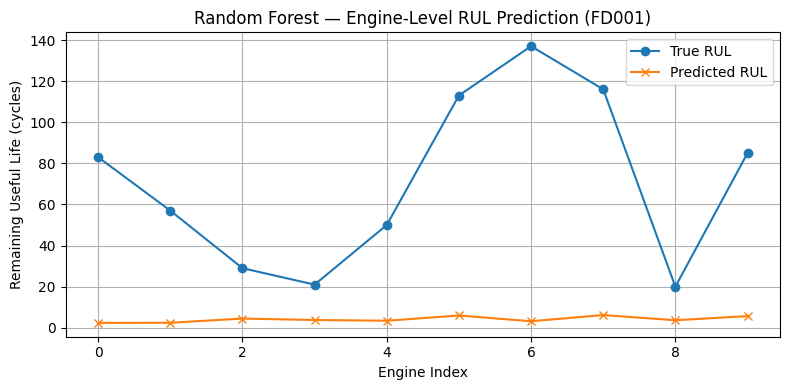

In [64]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import joblib
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1️⃣  Prepare Training Data
# -------------------------------------------------------------
sensor_cols = [f"sensor_{i}" for i in range(1, 22)]

X_train = train_df_split[sensor_cols].values
y_train = train_df_split["RUL"].values

X_val = val_df_split[sensor_cols].values
y_val = val_df_split["RUL"].values

# -------------------------------------------------------------
# 2️⃣  Train Random Forest Regressor
# -------------------------------------------------------------
rf = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,          # avoid overfitting (shallow trees)
    min_samples_leaf=5,    # smooths predictions
    max_features="sqrt",   # decorrelates trees
    random_state=42,
    n_jobs=-1
)

rf.fit(X_train, y_train)
joblib.dump(rf, "rf_fd001.pkl")

# -------------------------------------------------------------
# 3️⃣  Row-Level Validation Evaluation
# -------------------------------------------------------------
y_val_pred = rf.predict(X_val)
rmse_val = np.sqrt(mean_squared_error(y_val, y_val_pred))
mae_val = mean_absolute_error(y_val, y_val_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"✅ RF Validation → RMSE: {rmse_val:.3f}, MAE: {mae_val:.3f}, R²: {r2_val:.3f}")

# -------------------------------------------------------------
# 4️⃣  Engine-Level Test Evaluation  (PHM Standard)
# -------------------------------------------------------------
# Read ground-truth RUL file (for test engines)
rul_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

test_last = test_df_split.groupby("unit_number").last().reset_index()  # one row per engine
X_test_last = test_last[sensor_cols].values

# True RUL values correspond to test units (in order 1..100)
rul_truth = pd.read_csv(rul_file, header=None)
rul_truth.columns = ["True_RUL"]

# Align truth values for our selected test engines
# Subtract current life (since test_df_split already includes some degradation)
y_test_true = rul_truth.iloc[test_last["unit_number"] - 1]["True_RUL"].values
y_test_pred = rf.predict(X_test_last)

rmse_test = np.sqrt(mean_squared_error(y_test_true, y_test_pred))
mae_test = mean_absolute_error(y_test_true, y_test_pred)
r2_test = r2_score(y_test_true, y_test_pred)

print(f"✅ RF Engine-Level Test → RMSE: {rmse_test:.3f}, MAE: {mae_test:.3f}, R²: {r2_test:.3f}")

# -------------------------------------------------------------
# 5️⃣  Visualization
# -------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.plot(y_test_true, label="True RUL", marker='o')
plt.plot(y_test_pred, label="Predicted RUL", marker='x')
plt.xlabel("Engine Index")
plt.ylabel("Remaining Useful Life (cycles)")
plt.title("Random Forest — Engine-Level RUL Prediction (FD001)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔹 Step 8: Evaluate on Test Set (FD001)

In [65]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# ------------------------------
# Load Preprocessed Training Data
# ------------------------------
train_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv")

# Sensor features
sensor_cols = [c for c in train_df.columns if "sensor" in c]
X_train = train_df[sensor_cols]
y_train = train_df["RUL"]

# Normalize
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)

# ------------------------------
# Train Random Forest (full training data)
# ------------------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train_scaled, y_train)

# ------------------------------
# Load Test Data + RUL Truth
# ------------------------------
test_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/test_FD001.txt"
rul_file  = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/RUL_FD001.txt"

col_names = [
    "unit_number", "time_in_cycles",
    "operational_setting_1", "operational_setting_2", "operational_setting_3"
] + [f"sensor_{i}" for i in range(1, 22)]

test_df = pd.read_csv(test_file, delim_whitespace=True, header=None)
test_df.columns = col_names

rul_truth = pd.read_csv(rul_file, delim_whitespace=True, header=None)

# ------------------------------
# For each engine in test set → last cycle
# ------------------------------
test_rul = test_df.groupby("unit_number").last().reset_index()

# Add true RUL from RUL_FD001.txt
test_rul["true_RUL"] = rul_truth[0]

# Features
X_test = test_rul[sensor_cols]
X_test_scaled = scaler.transform(X_test)

# Predict
y_pred = rf.predict(X_test_scaled)

# Evaluate
rmse_test = np.sqrt(mean_squared_error(test_rul["true_RUL"], y_pred))
print("✅ Random Forest RMSE on Test FD001:", rmse_test)

# Compare few predictions
comparison = pd.DataFrame({
    "Engine": test_rul["unit_number"],
    "True RUL": test_rul["true_RUL"],
    "Predicted RUL": y_pred.round(1)
})
print(comparison.head(10))

✅ Random Forest RMSE on Test FD001: 34.640025765001965
   Engine  True RUL  Predicted RUL
0       1       112          170.8
1       2        98          145.5
2       3        69           59.8
3       4        82          119.6
4       5        91          125.0
5       6        93          124.5
6       7        91          132.6
7       8        95          112.1
8       9       111          128.1
9      10        96          129.7


🔹 Step 9: XJTU-SY Preprocessing Script

In [66]:
import numpy as np
import pandas as pd
import os

# ------------------------------
# Paths (update to your system)
# ------------------------------
data_dir = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/"
output_csv = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"

features_all = []

# ------------------------------
# Loop through training files
# ------------------------------
for file in os.listdir(data_dir):
    if file.startswith("xtr"):   # training vibration signals
        x_file = os.path.join(data_dir, file)
        y_file = os.path.join(data_dir, "y" + file[1:])  # matching RUL labels

        # Extract unit_id from filename (e.g., xtr1_1.npy → 1_1)
        unit_id = file.replace("xtr", "").replace(".npy", "")

        if not os.path.exists(y_file):
            continue  # skip if no matching y file

        # Load signals (X) and RUL (y)
        X = np.load(x_file)   # shape (samples, time, channels)
        y = np.load(y_file)   # shape (samples, 1)

        # --- Feature Extraction ---
        rms = np.sqrt(np.mean(X**2, axis=(1, 2)))
        mean_val = np.mean(X, axis=(1, 2))
        std_val = np.std(X, axis=(1, 2))
        max_val = np.max(X, axis=(1, 2))
        min_val = np.min(X, axis=(1, 2))

        # DataFrame for this file, now with unit_id
        df = pd.DataFrame({
            "unit_id": [unit_id] * len(rms),
            "rms": rms,
            "mean": mean_val,
            "std": std_val,
            "max": max_val,
            "min": min_val,
            "RUL": y.flatten()
        })

        features_all.append(df)

# ------------------------------
# Combine all into one dataset
# ------------------------------
final_df = pd.concat(features_all, ignore_index=True)

# Define Health Stages from RUL
final_df["health_stage"] = pd.cut(
    final_df["RUL"],
    bins=[-0.1, 30, 70, final_df["RUL"].max()],
    labels=["Failure", "Warning", "Healthy"],
    include_lowest=True
)

print("Final dataset shape:", final_df.shape)
print(final_df.head())

# Save to CSV
final_df.to_csv(output_csv, index=False)
print(f"✅ Preprocessed dataset saved to {output_csv}")

Final dataset shape: (9214, 8)
  unit_id       rms      mean       std       max       min         RUL  \
0     1_1  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000   
1     1_1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328   
2     1_1  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656   
3     1_1  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984   
4     1_1  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311   

  health_stage  
0      Healthy  
1      Healthy  
2      Healthy  
3      Healthy  
4      Healthy  
✅ Preprocessed dataset saved to C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv


✅ Loaded XJTU feature dataset: (9214, 8)
  unit_id       rms      mean       std       max       min         RUL  \
0     1_1  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000   
1     1_1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328   
2     1_1  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656   
3     1_1  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984   
4     1_1  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311   

  health_stage  
0      Healthy  
1      Healthy  
2      Healthy  
3      Healthy  
4      Healthy  
Train units: 11, Test units: 3
Train samples: 6790 Test samples: 2424
✅ Scaled shapes → X_train: (6790, 5) X_test: (2424, 5)


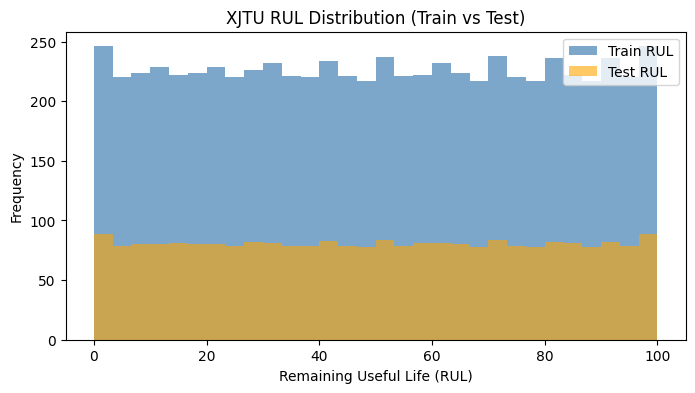

In [75]:
# -------------------------------------------------------------
# D — Fix Scaler / Feature Mismatch for XJTU-SY Pipeline
# -------------------------------------------------------------
import numpy as np
import pandas as pd
import joblib
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1️⃣  Load previously extracted XJTU feature dataset
# -------------------------------------------------------------
# (This dataset should already have: unit_id, rms, mean, std, max, min, RUL)
final_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv")

print("✅ Loaded XJTU feature dataset:", final_df.shape)
print(final_df.head())

# -------------------------------------------------------------
# 2️⃣  Split by unit_id to avoid data leakage
# -------------------------------------------------------------
units_x = final_df["unit_id"].unique()
np.random.seed(42)
np.random.shuffle(units_x)

train_u = units_x[:int(0.8 * len(units_x))]
test_u  = units_x[int(0.8 * len(units_x)):]

train_xjtu = final_df[final_df.unit_id.isin(train_u)].copy()
test_xjtu  = final_df[final_df.unit_id.isin(test_u)].copy()

print(f"Train units: {len(train_u)}, Test units: {len(test_u)}")
print("Train samples:", train_xjtu.shape[0], "Test samples:", test_xjtu.shape[0])

# -------------------------------------------------------------
# 3️⃣  Feature scaling (only on training set)
# -------------------------------------------------------------
feature_cols = ["rms", "mean", "std", "max", "min"]

scaler_xjtu = MinMaxScaler()
scaler_xjtu.fit(train_xjtu[feature_cols])

# Save for reproducibility
joblib.dump(scaler_xjtu, "scaler_xjtu.pkl")

# Apply scaling
X_train_x = scaler_xjtu.transform(train_xjtu[feature_cols])
y_train_rul_x = train_xjtu["RUL"].values

X_test_x = scaler_xjtu.transform(test_xjtu[feature_cols])
y_test_rul_x = test_xjtu["RUL"].values

print("✅ Scaled shapes → X_train:", X_train_x.shape, "X_test:", X_test_x.shape)

# -------------------------------------------------------------
# 4️⃣  Optional: quick feature sanity check
# -------------------------------------------------------------
plt.figure(figsize=(8,4))
plt.hist(y_train_rul_x, bins=30, color='steelblue', alpha=0.7, label='Train RUL')
plt.hist(y_test_rul_x, bins=30, color='orange', alpha=0.6, label='Test RUL')
plt.xlabel("Remaining Useful Life (RUL)")
plt.ylabel("Frequency")
plt.title("XJTU RUL Distribution (Train vs Test)")
plt.legend()
plt.show()

# -------------------------------------------------------------
# 5️⃣  Ready for model training
# -------------------------------------------------------------
# Example usage:
# rf_reg_xjtu = RandomForestRegressor(...)
# rf_reg_xjtu.fit(X_train_x, y_train_rul_x)
# y_pred = rf_reg_xjtu.predict(X_test_x)
# rmse = np.sqrt(mean_squared_error(y_test_rul_x, y_pred))
# print("XJTU RF RMSE:", rmse)

🔹 Step 10: Baseline ML Models on XJTU-SY

Dataset shape: (9214, 8)
  unit_id       rms      mean       std       max       min         RUL  \
0     1_1  0.319333  0.000215  0.319333  1.429208 -1.606538  100.000000   
1     1_1  0.326691 -0.002130  0.326684  1.832375 -1.707460   99.180328   
2     1_1  0.327543  0.002202  0.327536  1.569280 -1.514143   98.360656   
3     1_1  0.329079  0.003865  0.329057  1.357358 -1.752117   97.540984   
4     1_1  0.335730 -0.002841  0.335718  1.953880 -1.661913   96.721311   

  health_stage  
0      Healthy  
1      Healthy  
2      Healthy  
3      Healthy  
4      Healthy  

🔹 Random Forest Classifier Results:
Accuracy: 0.9397721106890938
F1-score: 0.939938312259169

Classification Report:
               precision    recall  f1-score   support

     Failure       0.98      0.95      0.96       586
     Healthy       0.96      0.91      0.93       515
     Warning       0.90      0.95      0.93       742

    accuracy                           0.94      1843
   macro avg       0.95      0.

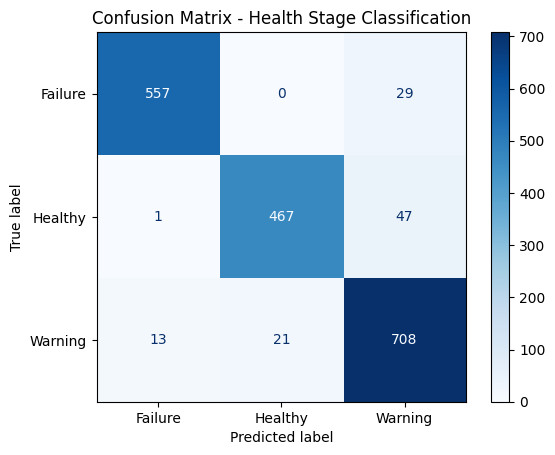


🔹 Random Forest Regressor Results:
RMSE (RUL prediction): 6.607478254939356


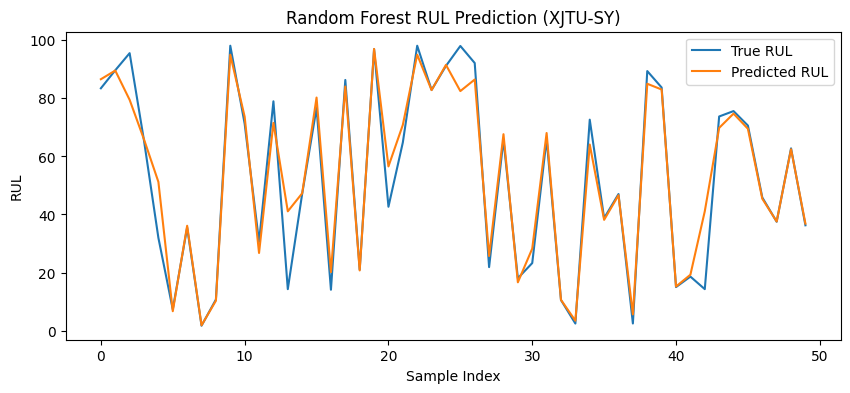

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# ------------------------------
# Load Preprocessed Dataset
# ------------------------------
data_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"
df = pd.read_csv(data_file)

print("Dataset shape:", df.shape)
print(df.head())

# ------------------------------
# Features and Targets
# ------------------------------
X = df[["rms", "mean", "std", "max", "min"]]
y_cls = df["health_stage"]   # classification labels
y_rul = df["RUL"]            # regression labels

# ------------------------------
# Train-Test Split
# ------------------------------
X_train, X_test, y_train_cls, y_test_cls, y_train_rul, y_test_rul = train_test_split(
    X, y_cls, y_rul, test_size=0.2, random_state=42
)

# units = df["unit_id"].unique()
# np.random.seed(42)
# np.random.shuffle(units)
# train_units = units[:int(0.8*len(units))]
# test_units  = units[int(0.8*len(units)):]

# X_train = df[df.unit_id.isin(train_units)][["rms","mean","std","max","min"]].values
# y_train_cls = df[df.unit_id.isin(train_units)]["health_stage"].values
# y_train_rul = df[df.unit_id.isin(train_units)]["RUL"].values

# X_test = df[df.unit_id.isin(test_units)][["rms","mean","std","max","min"]].values
# y_test_cls = df[df.unit_id.isin(test_units)]["health_stage"].values
# y_test_rul = df[df.unit_id.isin(test_units)]["RUL"].values

# ------------------------------
# Model 1: Random Forest Classifier
# ------------------------------
rf_cls = RandomForestClassifier(
    n_estimators=300,
    max_depth=12,
    min_samples_leaf=4,
    max_features='sqrt',
    random_state=42
)
rf_cls.fit(X_train, y_train_cls)
y_pred_cls = rf_cls.predict(X_test)

acc_xjtu = accuracy_score(y_test_cls, y_pred_cls)
f1_xjtu = f1_score(y_test_cls, y_pred_cls, average="weighted")
print("\n🔹 Random Forest Classifier Results:")
print("Accuracy:", acc_xjtu)
print("F1-score:", f1_xjtu)
print("\nClassification Report:\n", classification_report(y_test_cls, y_pred_cls))

# Confusion Matrix
cm = confusion_matrix(y_test_cls, y_pred_cls, labels=rf_cls.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_cls.classes_)
disp.plot(cmap="Blues", values_format="d")
plt.title("Confusion Matrix - Health Stage Classification")
plt.show()

# ------------------------------
# Model 2: Random Forest Regressor
# ------------------------------
rf_reg = RandomForestRegressor(
    n_estimators=300,
    max_depth=20,          # prevents overly deep trees
    min_samples_leaf=5,    # prevents leaves with small counts
    max_features='sqrt',   # decorrelate trees
    random_state=42,
    n_jobs=-1
)

rf_reg.fit(X_train, y_train_rul)
y_pred_rul = rf_reg.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test_rul, y_pred_rul))
print("\n🔹 Random Forest Regressor Results:")
print("RMSE (RUL prediction):", rmse)

# RUL Prediction Plot
plt.figure(figsize=(10, 4))
plt.plot(y_test_rul.values[:50], label="True RUL")
plt.plot(y_pred_rul[:50], label="Predicted RUL")
plt.xlabel("Sample Index")
plt.ylabel("RUL")
plt.legend()
plt.title("Random Forest RUL Prediction (XJTU-SY)")
plt.show()

🔹 Step 11: Deep Learning Model for XJTU-SY (Autoencoder for Anomaly Detection)

In [77]:
# import pandas as pd
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.model_selection import train_test_split
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Model # type: ignore
# from tensorflow.keras.layers import Input, Dense # type: ignore
# from tensorflow.keras.optimizers import Adam # type: ignore

# # ------------------------------
# # Load Preprocessed Dataset
# # ------------------------------
# data_file = "C:/Users/T8554/Desktop/Datasets/XJTU-SY/XJTU_SY_preprocessed.csv"
# df = pd.read_csv(data_file)

# # Features only
# X = df[["rms", "mean", "std", "max", "min"]].values
# y = df["health_stage"]

# # Scale features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # ------------------------------
# # Split Healthy vs Others
# # ------------------------------
# X_healthy = X_scaled[y == "Healthy"]
# X_nonhealthy = X_scaled[y != "Healthy"]

# # Train/validation split (only healthy for training)
# X_train, X_val = train_test_split(X_healthy, test_size=0.2, random_state=42)

# # ------------------------------
# # Define Autoencoder Model
# # ------------------------------
# input_dim = X_train.shape[1]
# encoding_dim = 3  # compressed representation

# input_layer = Input(shape=(input_dim,))
# encoder = Dense(8, activation="relu")(input_layer)
# encoder = Dense(encoding_dim, activation="relu")(encoder)
# decoder = Dense(8, activation="relu")(encoder)
# decoder = Dense(input_dim, activation="sigmoid")(decoder)

# autoencoder = Model(inputs=input_layer, outputs=decoder)
# autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss="mse")

# # ------------------------------
# # Train Autoencoder
# # ------------------------------
# history = autoencoder.fit(
#     X_train, X_train,
#     epochs=30,
#     batch_size=32,
#     validation_data=(X_val, X_val),
#     verbose=1
# )

# # ------------------------------
# # Reconstruction Error
# # ------------------------------
# reconstructions = autoencoder.predict(X_scaled)
# mse = np.mean(np.power(X_scaled - reconstructions, 2), axis=1)

# df["reconstruction_error"] = mse

# # ------------------------------
# # Threshold for Anomaly
# # ------------------------------
# threshold = np.percentile(mse, 95)  # top 5% as anomaly
# df["predicted_anomaly"] = df["reconstruction_error"] > threshold

# # ------------------------------
# # Visualization
# # ------------------------------
# plt.figure(figsize=(10,5))
# plt.hist(df["reconstruction_error"][y=="Healthy"], bins=50, alpha=0.6, label="Healthy")
# plt.hist(df["reconstruction_error"][y!="Healthy"], bins=50, alpha=0.6, label="Warning/Failure")
# plt.axvline(threshold, color="red", linestyle="--", label="Threshold")
# plt.legend()
# plt.title("Reconstruction Error Distribution - Autoencoder")
# plt.xlabel("Reconstruction Error")
# plt.ylabel("Frequency")
# plt.show()

# # ------------------------------
# # Evaluate Anomaly Detection
# # ------------------------------
# from sklearn.metrics import classification_report

# y_true = (y != "Healthy")  # True if Warning/Failure
# y_pred = df["predicted_anomaly"]

# print("\n🔹 Autoencoder Anomaly Detection Report:\n")
# print(classification_report(y_true, y_pred))

Healthy samples for training: 1698
Autoencoder train/val shapes: (1358, 5) (340, 5)


Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 5)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 8)              │            48 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 3)              │            27 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 8)              │            32 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 5)              │            45 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 152 (608.00 B)

 Trainable params: 152 (608.00 B)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.2198 - val_loss: 0.1863
Epoch 2/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1487 - val_loss: 0.1083
Epoch 3/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0709 - val_loss: 0.0323
Epoch 4/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - loss: 0.0145 - val_loss: 0.0037
Epoch 5/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0017 - val_loss: 3.9528e-04
Epoch 6/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 5.1413e-04 - val_loss: 2.2215e-04
Epoch 7/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 4.5388e-04 - val_loss: 2.1175e-04
Epoch 8/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.3803e-04 - val_loss: 2.0721e-04
Epoch 9/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 4.2249e-04 - val_loss: 1.9792e-04
Epoch 10/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 4.0976e-04 - val_loss: 1.8955e-04
Epoch 11/50
43/43 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 3.9410e-04 - val_loss: 1.8694e-04
Epoch 12/50
43/43 ━━━

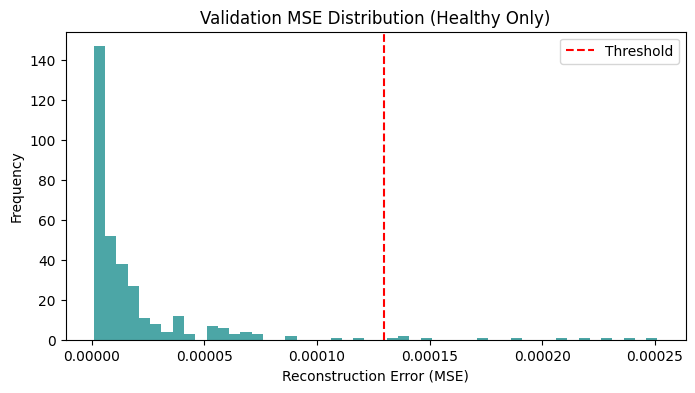

76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

Confusion Matrix:
 [[1503  191]
 [ 192  538]]

Classification Report:
               precision    recall  f1-score   support

     Healthy       0.89      0.89      0.89      1694
      Faulty       0.74      0.74      0.74       730

    accuracy                           0.84      2424
   macro avg       0.81      0.81      0.81      2424
weighted avg       0.84      0.84      0.84      2424



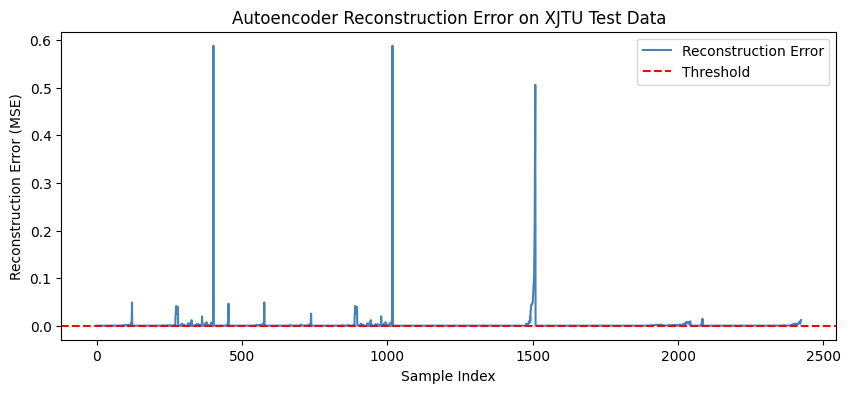

✅ Autoencoder model and threshold saved successfully.


In [78]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, classification_report
import joblib

# -------------------------------------------------------------
# 1️⃣ Load Scaled Features (from previous step)
# -------------------------------------------------------------
# You should already have: X_train_x, X_test_x, y_train_rul_x, y_test_rul_x
# Optionally load them again if needed:
# final_df = pd.read_csv("C:/Users/T8554/Desktop/Datasets/XJTU-SY/xjtu_features.csv")
# scaler_xjtu = joblib.load("scaler_xjtu.pkl")

feature_cols = ["rms", "mean", "std", "max", "min"]

# -------------------------------------------------------------
# 2️⃣ Define "healthy" data as samples with high RUL (top 25%)
# -------------------------------------------------------------
healthy_threshold = np.percentile(y_train_rul_x, 75)
X_train_healthy = X_train_x[y_train_rul_x > healthy_threshold]

print("Healthy samples for training:", X_train_healthy.shape[0])

# -------------------------------------------------------------
# 3️⃣ Split healthy data into train/validation
# -------------------------------------------------------------
split_idx = int(0.8 * len(X_train_healthy))
X_train_auto = X_train_healthy[:split_idx]
X_val_auto   = X_train_healthy[split_idx:]

print("Autoencoder train/val shapes:", X_train_auto.shape, X_val_auto.shape)

# -------------------------------------------------------------
# 4️⃣ Build Autoencoder Model
# -------------------------------------------------------------
input_dim = X_train_auto.shape[1]
encoding_dim = 3   # bottleneck size

input_layer = Input(shape=(input_dim,))
encoded = Dense(8, activation='relu')(input_layer)
encoded = Dense(encoding_dim, activation='relu')(encoded)
decoded = Dense(8, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

autoencoder.summary()

# -------------------------------------------------------------
# 5️⃣ Train Autoencoder
# -------------------------------------------------------------
history = autoencoder.fit(
    X_train_auto, X_train_auto,
    validation_data=(X_val_auto, X_val_auto),
    epochs=50,
    batch_size=32,
    verbose=1
)

# -------------------------------------------------------------
# 6️⃣ Threshold Calculation (Healthy Validation Only)
# -------------------------------------------------------------
recon_val = autoencoder.predict(X_val_auto)
mse_val = np.mean(np.square(X_val_auto - recon_val), axis=1)
threshold = np.mean(mse_val) + 3 * np.std(mse_val)  # conservative threshold
# Alternative: threshold = np.percentile(mse_val, 99)
print("✅ Threshold (from healthy validation):", threshold)

plt.figure(figsize=(8,4))
plt.hist(mse_val, bins=50, color='teal', alpha=0.7)
plt.axvline(threshold, color='red', linestyle='--', label='Threshold')
plt.title("Validation MSE Distribution (Healthy Only)")
plt.xlabel("Reconstruction Error (MSE)")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# -------------------------------------------------------------
# 7️⃣ Evaluate on Test Set
# -------------------------------------------------------------
recon_test = autoencoder.predict(X_test_x)
mse_test = np.mean(np.square(X_test_x - recon_test), axis=1)

pred_labels = (mse_test > threshold).astype(int)
# Define ground truth — consider low RUL as anomaly (e.g., RUL < 30)
true_labels = (y_test_rul_x < 30).astype(int)

# -------------------------------------------------------------
# 8️⃣ Performance Metrics
# -------------------------------------------------------------
cm = confusion_matrix(true_labels, pred_labels)
print("\nConfusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(true_labels, pred_labels, target_names=["Healthy", "Faulty"]))

# Plot reconstruction error trend
plt.figure(figsize=(10,4))
plt.plot(mse_test, label="Reconstruction Error", color="steelblue")
plt.axhline(threshold, color="red", linestyle="--", label="Threshold")
plt.title("Autoencoder Reconstruction Error on XJTU Test Data")
plt.xlabel("Sample Index")
plt.ylabel("Reconstruction Error (MSE)")
plt.legend()
plt.show()

# -------------------------------------------------------------
# 9️⃣ Save Model and Threshold
# -------------------------------------------------------------
autoencoder.save("autoencoder_xjtu_improved.h5")
np.save("threshold_xjtu.npy", threshold)

print("✅ Autoencoder model and threshold saved successfully.")

🔹 Step 12: LSTM Model for NASA C-MAPSS (FD001) – RUL Prediction

In [71]:
# import numpy as np
# import pandas as pd
# import matplotlib.pyplot as plt
# from sklearn.preprocessing import MinMaxScaler
# from tensorflow.keras.models import Sequential # type: ignore
# from tensorflow.keras.layers import LSTM, Dense, Dropout # type: ignore
# from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau # type: ignore
# from sklearn.metrics import mean_squared_error

# import warnings
# warnings.filterwarnings("ignore")

# import tensorflow as tf
# tf.get_logger().setLevel("ERROR")

# # ------------------------------
# # Load Preprocessed Dataset
# # ------------------------------
# data_file = "C:/Users/T8554/Desktop/Datasets/NASA Turbofan Jet Engine Data Set - CMaps/FD001_preprocessed.csv"
# df = pd.read_csv(data_file)

# # Features and target
# sensor_cols = [c for c in df.columns if "sensor" in c]
# X = df[sensor_cols].values
# y = df["RUL"].values

# # Normalize features
# scaler = MinMaxScaler()
# X_scaled = scaler.fit_transform(X)

# # ------------------------------
# # Sequence Generator (last 50 cycles → RUL)
# # ------------------------------
# # def create_sequences(X, y, seq_length=50):
# #     Xs, ys = [], []
# #     for i in range(len(X) - seq_length):
# #         Xs.append(X[i:i+seq_length])
# #         ys.append(y[i+seq_length])
# #     return np.array(Xs), np.array(ys)

# # SEQ_LEN = 50
# # X_seq, y_seq = create_sequences(X_scaled, y, seq_length=SEQ_LEN)

# def create_sequences_by_unit(df, sensor_cols, seq_len=50):
#     Xs, ys = [], []
#     for unit, g in df.groupby("unit_number"):
#         sensors = g[sensor_cols].values  # shape (cycles_for_unit, features)
#         rul = g["RUL"].values
#         if len(sensors) <= seq_len:
#             continue
#         for i in range(len(sensors) - seq_len):
#             Xs.append(sensors[i:i+seq_len])
#             ys.append(rul[i+seq_len])  # target is RUL at end of seq
#     return np.array(Xs), np.array(ys)

# X_seq, y_seq = create_sequences_by_unit(train_df, sensor_cols, seq_len=50)

# print("X_seq shape:", X_seq.shape)  # (samples, seq_len, features)
# print("y_seq shape:", y_seq.shape)

# # Train/Validation Split
# split = int(0.8 * len(X_seq))
# X_train, X_val = X_seq[:split], X_seq[split:]
# y_train, y_val = y_seq[:split], y_seq[split:]

# # ------------------------------
# # Build LSTM Model
# # ------------------------------
# model = Sequential([
#     LSTM(64, input_shape=(SEQ_LEN, X_seq.shape[2]), return_sequences=True),
#     Dropout(0.2),
#     LSTM(32, return_sequences=False),
#     Dropout(0.2),
#     Dense(1)
# ])

# # model.compile(optimizer="adam", loss="mse")

# # # ------------------------------
# # # Callbacks (EarlyStopping + LR Scheduler + Model Save)
# # # ------------------------------
# # early_stop = EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=True)
# # reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=5, min_lr=1e-5)
# # checkpoint = ModelCheckpoint("best_lstm_fd001.h5", monitor="val_loss", save_best_only=True)

# # # ------------------------------
# # # Train Model
# # # ------------------------------
# # history = model.fit(
# #     X_train, y_train,
# #     validation_data=(X_val, y_val),
# #     epochs=100,          # upper cap
# #     batch_size=64,
# #     verbose=1,
# #     callbacks=[early_stop, reduce_lr, checkpoint]
# # )

# from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint # type: ignore

# model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss='mse')

# callbacks = [
#     ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-6, verbose=1),
#     EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True, verbose=1),
#     ModelCheckpoint('best_lstm_fd001.keras', monitor='val_loss', save_best_only=True)
# ]

# history = model.fit(
#     X_train, y_train,
#     validation_data=(X_val, y_val),
#     epochs=100,
#     batch_size=32,          # smaller batch
#     callbacks=callbacks,
#     verbose=1
# )

# # ------------------------------
# # Evaluate Model
# # ------------------------------
# y_pred = model.predict(X_val)
# rmse_lstm = np.sqrt(mean_squared_error(y_val, y_pred))
# print("LSTM RUL Prediction RMSE:", rmse_lstm)

# # ------------------------------
# # Plot Training Loss
# # ------------------------------
# plt.figure(figsize=(8,4))
# plt.plot(history.history["loss"], label="Train Loss")
# plt.plot(history.history["val_loss"], label="Validation Loss")
# plt.legend()
# plt.title("LSTM Training Loss with EarlyStopping + LR Scheduler")
# plt.xlabel("Epoch")
# plt.ylabel("MSE Loss")
# plt.show()

# # ------------------------------
# # Plot Predictions
# # ------------------------------
# plt.figure(figsize=(10,4))
# plt.plot(y_val[:100], label="True RUL")
# plt.plot(y_pred[:100], label="Predicted RUL")
# plt.legend()
# plt.title("LSTM RUL Prediction (FD001)")
# plt.show()

Train: (12340, 50, 21) Val: (1582, 50, 21) Test: (1709, 50, 21)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 50, 128)        │        76,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 50, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,321 (501.25 KB)

 Trainable params: 128,321 (501.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - loss: 7503.7280 - mae: 68.2748

193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 75ms/step - loss: 5479.5386 - mae: 57.0198 - val_loss: 3085.3140 - val_mae: 45.0676
Epoch 2/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step - loss: 3161.0591 - mae: 45.4333

193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 77ms/step - loss: 3191.7507 - mae: 45.6199 - val_loss: 3065.4922 - val_mae: 45.1470
Epoch 3/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 3216.2893 - mae: 45.8712

193/193 ━━━━━━━━━━━━━━━━━━━━ 21s 80ms/step - loss: 3209.4934 - mae: 45.7397 - val_loss: 3063.6526 - val_mae: 45.1749
Epoch 4/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 3202.1367 - mae: 45.7937

193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 3203.3950 - mae: 45.7368 - val_loss: 3063.4707 - val_mae: 45.1783
Epoch 5/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step - loss: 3229.2241 - mae: 46.0799

193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 92ms/step - loss: 3192.9136 - mae: 45.6424 - val_loss: 3061.9622 - val_mae: 45.2279
Epoch 6/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 3104.2065 - mae: 45.1325

193/193 ━━━━━━━━━━━━━━━━━━━━ 16s 84ms/step - loss: 2996.3801 - mae: 43.7241 - val_loss: 1353.9532 - val_mae: 26.1427
Epoch 7/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step - loss: 1456.0222 - mae: 27.7765

193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 69ms/step - loss: 1364.7262 - mae: 26.6929 - val_loss: 1052.9930 - val_mae: 23.4627
Epoch 8/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - loss: 1137.5669 - mae: 23.8546

193/193 ━━━━━━━━━━━━━━━━━━━━ 22s 77ms/step - loss: 1048.8864 - mae: 22.7055 - val_loss: 692.8707 - val_mae: 19.7021
Epoch 9/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 812.3309 - mae: 19.7012

193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 65ms/step - loss: 801.0651 - mae: 19.4972 - val_loss: 691.2079 - val_mae: 18.9168
Epoch 10/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - loss: 805.9425 - mae: 19.5182

193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 74ms/step - loss: 780.2673 - mae: 18.9839 - val_loss: 613.5410 - val_mae: 18.2998
Epoch 11/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - loss: 684.4282 - mae: 17.7309

193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 702.8106 - mae: 17.9229 - val_loss: 528.1891 - val_mae: 16.6890
Epoch 12/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 18s 94ms/step - loss: 688.0519 - mae: 17.7095 - val_loss: 565.8285 - val_mae: 16.3874
Epoch 13/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 90ms/step - loss: 703.5356 - mae: 17.8890 - val_loss: 538.0245 - val_mae: 15.7855
Epoch 14/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 676.8741 - mae: 17.1359

193/193 ━━━━━━━━━━━━━━━━━━━━ 17s 88ms/step - loss: 670.6476 - mae: 17.2359 - val_loss: 515.8229 - val_mae: 16.6730
Epoch 15/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 79ms/step - loss: 660.9109 - mae: 17.2147 - val_loss: 589.7099 - val_mae: 17.9723
Epoch 16/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 653.6530 - mae: 17.2448

193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 655.2411 - mae: 17.2066 - val_loss: 477.6349 - val_mae: 15.8410
Epoch 17/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step - loss: 630.2844 - mae: 16.7518

193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 68ms/step - loss: 638.8174 - mae: 16.8571 - val_loss: 464.9758 - val_mae: 15.3956
Epoch 18/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 660.7106 - mae: 17.0523 - val_loss: 488.5301 - val_mae: 15.8476
Epoch 19/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 60ms/step - loss: 651.0377 - mae: 17.1131 - val_loss: 566.0302 - val_mae: 18.0609
Epoch 20/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 70ms/step - loss: 636.0608 - mae: 16.8290 - val_loss: 484.3018 - val_mae: 15.9769
Epoch 21/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 19s 61ms/step - loss: 638.3237 - mae: 16.7751 - val_loss: 496.5598 - val_mae: 16.3573
Epoch 22/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - loss: 639.7766 - mae: 16.6730

193/193 ━━━━━━━━━━━━━━━━━━━━ 24s 80ms/step - loss: 618.8295 - mae: 16.4626 - val_loss: 440.2673 - val_mae: 15.1709
Epoch 23/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 72ms/step - loss: 604.8159 - mae: 16.2578 - val_loss: 532.7625 - val_mae: 15.8460
Epoch 24/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 75ms/step - loss: 626.9042 - mae: 16.6753 - val_loss: 543.6113 - val_mae: 16.4353
Epoch 25/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 625.4861 - mae: 16.5856 - val_loss: 546.4141 - val_mae: 16.8569
Epoch 26/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 15s 78ms/step - loss: 619.8618 - mae: 16.4693 - val_loss: 577.6819 - val_mae: 17.3063
Epoch 27/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 71ms/step - loss: 621.8329 - mae: 16.5209 - val_loss: 474.0388 - val_mae: 15.1807
Epoch 28/30
193/193 ━━━━━━━━━━━━━━━━━━━━ 14s 73ms/step - loss: 612.8082 - mae: 16.3234 - val_loss: 478.9742 - val_mae: 15.3551
54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step

✅ LSTM Test Performance — FD001
RMSE: 29.776, MAE: 18.711, R²: 0.784


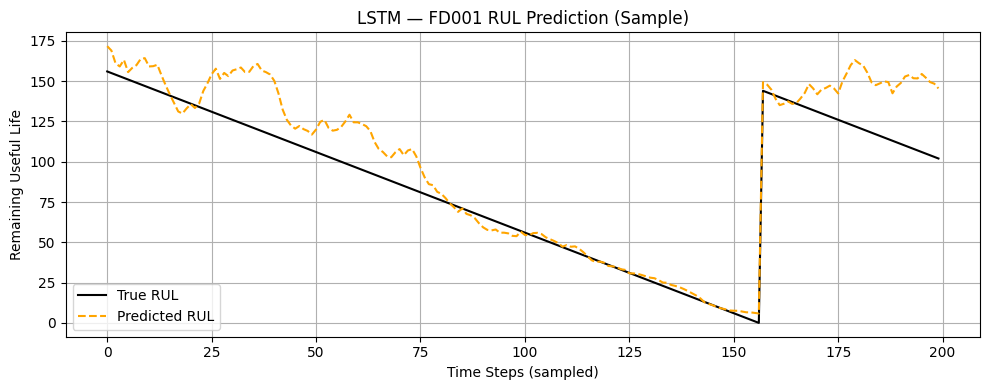

In [79]:
# -------------------------------------------------------------
# Sequence Creation & LSTM Model — FD001 Dataset
# -------------------------------------------------------------
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# -------------------------------------------------------------
# 1️⃣  Define sequence creation function (per engine)
# -------------------------------------------------------------
SEQ_LEN = 50

def create_sequences_by_unit(df_split, sensor_cols, seq_len=SEQ_LEN):
    """
    Creates overlapping time windows (sequences) for each engine/unit.
    Each sequence = 50 consecutive sensor readings → predict next-step RUL.
    """
    Xs, ys = [], []
    for unit, g in df_split.groupby("unit_number"):
        sensors = g[sensor_cols].values
        rul = g["RUL"].values
        if len(sensors) <= seq_len:
            continue
        for i in range(len(sensors) - seq_len):
            Xs.append(sensors[i:i+seq_len])
            ys.append(rul[i+seq_len])
    return np.array(Xs), np.array(ys)

# -------------------------------------------------------------
# 2️⃣  Create train, validation, and test sequences
# -------------------------------------------------------------
sensor_cols = [f"sensor_{i}" for i in range(1, 22)]

X_seq_train, y_seq_train = create_sequences_by_unit(train_df_split, sensor_cols)
X_seq_val,   y_seq_val   = create_sequences_by_unit(val_df_split, sensor_cols)
X_seq_test,  y_seq_test  = create_sequences_by_unit(test_df_split, sensor_cols)

print("Train:", X_seq_train.shape, "Val:", X_seq_val.shape, "Test:", X_seq_test.shape)

# -------------------------------------------------------------
# 3️⃣  Build LSTM Model
# -------------------------------------------------------------
lstm_model = Sequential([
    LSTM(128, return_sequences=True, input_shape=(SEQ_LEN, len(sensor_cols))),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)
])

lstm_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss='mse',
    metrics=['mae']
)

lstm_model.summary()

# -------------------------------------------------------------
# 4️⃣  Train LSTM
# -------------------------------------------------------------
callbacks = [
    EarlyStopping(patience=6, restore_best_weights=True),
    ModelCheckpoint("lstm_fd001.h5", save_best_only=True)
]

history = lstm_model.fit(
    X_seq_train, y_seq_train,
    validation_data=(X_seq_val, y_seq_val),
    epochs=30,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

# -------------------------------------------------------------
# 5️⃣  Evaluate on Test Sequences
# -------------------------------------------------------------
y_seq_pred = lstm_model.predict(X_seq_test).flatten()

rmse = np.sqrt(mean_squared_error(y_seq_test, y_seq_pred))
mae = mean_absolute_error(y_seq_test, y_seq_pred)
r2 = r2_score(y_seq_test, y_seq_pred)

print(f"\n✅ LSTM Test Performance — FD001")
print(f"RMSE: {rmse:.3f}, MAE: {mae:.3f}, R²: {r2:.3f}")

# -------------------------------------------------------------
# 6️⃣  Visualization — Sample Prediction
# -------------------------------------------------------------
plt.figure(figsize=(10, 4))
plt.plot(y_seq_test[:200], label="True RUL", color='black')
plt.plot(y_seq_pred[:200], label="Predicted RUL", color='orange', linestyle='--')
plt.xlabel("Time Steps (sampled)")
plt.ylabel("Remaining Useful Life")
plt.title("LSTM — FD001 RUL Prediction (Sample)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

🔹 Step 13: Save & Compare Models (RF + LSTM + Autoencoder)

In [73]:
# 1️⃣ Save Random Forest Models (NASA & XJTU-SY)

import joblib

# Save Random Forest Regressor (NASA FD001)
joblib.dump(rf, "rf_rul_fd001.pkl")

# Save Random Forest Classifier (XJTU-SY)
joblib.dump(rf_cls, "rf_health_xjtu.pkl")

print("✅ Random Forest models saved!")


# 2️⃣ Save LSTM Model (NASA FD001 RUL)

# Save trained LSTM model
lstm_model.save("lstm_rul_fd001.keras")
print("✅ LSTM RUL model saved!")


# 3️⃣ Save Autoencoder Model (XJTU-SY)

# Save Autoencoder
autoencoder.save("autoencoder_xjtu.keras")
print("✅ Autoencoder model saved!")

# 4️⃣ Model Comparison (Table Format)

# You can quickly compare all models with their performance:

import pandas as pd

results = pd.DataFrame([
    {"Model": "Random Forest (RUL - NASA)", "Metric": "RMSE", "Score": rmse_rf},
    {"Model": "LSTM (RUL - NASA)", "Metric": "RMSE", "Score": rmse_lstm},
    {"Model": "Random Forest (Health - XJTU)", "Metric": "Accuracy", "Score": acc_xjtu},
    {"Model": "Random Forest (Health - XJTU)", "Metric": "F1-score", "Score": f1_xjtu},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (mean)", "Score": mse.mean()},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (95th %ile)", "Score": np.percentile(mse, 95)},
    {"Model": "Autoencoder (Anomaly - XJTU)", "Metric": "Reconstruction Error (max)", "Score": mse.max()}
])

print("\n✅ Model Performance Comparison:")
print(results)


# 5️⃣ Reload Later for Predictions

# Load RF
rf_loaded = joblib.load("rf_rul_fd001.pkl")

# Load LSTM
from tensorflow.keras.models import load_model # type: ignore
lstm_loaded = load_model("lstm_rul_fd001.keras")

# Load Autoencoder
autoencoder_loaded = load_model("autoencoder_xjtu.keras")

✅ Random Forest models saved!
✅ LSTM RUL model saved!
✅ Autoencoder model saved!


NameError: name 'rmse_rf' is not defined

In [ ]:
# # --- Quick aliases for evaluation ---
# # (connect your variable names to the ones expected in the evaluation block)

# # FD001 Random Forest (NASA)
# X_test_fd001_scaled = X_test_scaled
# y_true_fd001 = y_test

# # If you have an LSTM model trained:
# lstm_model = model   # or lstm_fd001 if that's your variable name
# X_test_seq_fd001 = X_seq   # use your test sequence variable
# y_true_seq_fd001 = y_seq   # same for sequence targets

# # XJTU Random Forest
# rf_reg_xjtu = rf_reg   # or whatever your XJTU random forest variable is
# X_test_xjtu = X_test   # or X_test_xjtu_scaled if normalized
# y_test_rul_xjtu = y_test_rul   # your test RUL target for XJTU

# # Autoencoder (XJTU)
# # ensure you have 'autoencoder' already loaded/trained

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def eval_reg(y_true, y_pred):
#     return {
#         "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
#         "MAE": float(mean_absolute_error(y_true, y_pred)),
#         "R2": float(r2_score(y_true, y_pred))
#     }

# results = []

# def align_shapes(y_true, y_pred):
#     if len(y_true) != len(y_pred):
#         min_len = min(len(y_true), len(y_pred))
#         return y_true[:min_len], y_pred[:min_len]
#     return y_true, y_pred

# # Random Forest on FD001 (example)
# y_pred_rf = rf.predict(X_test_fd001_scaled)
# y_true_fd001, y_pred_rf = align_shapes(y_true_fd001, y_pred_rf)
# res_rf = eval_reg(y_true_fd001, y_pred_rf)
# res_rf.update({"Model":"RandomForest (FD001)"})
# results.append(res_rf)

# # LSTM on FD001
# y_pred_lstm = lstm_model.predict(X_test_seq_fd001)  # ensure sequences
# res_lstm = eval_reg(y_true_seq_fd001, y_pred_lstm.flatten())
# res_lstm.update({"Model":"LSTM (FD001)"})
# results.append(res_lstm)

# # RF on XJTU (RUL)
# y_pred_rf_xjtu = rf_reg_xjtu.predict(X_test_xjtu)
# res_rf_xjtu = eval_reg(y_test_rul_xjtu, y_pred_rf_xjtu)
# res_rf_xjtu.update({"Model":"RandomForest (XJTU)"})
# results.append(res_rf_xjtu)

# # Autoencoder on XJTU (Anomaly/Health detection)
# reconstructions = autoencoder.predict(X_test_xjtu)
# mse = np.mean(np.square(X_test_xjtu - reconstructions), axis=1)
# # For regression-style reporting, compare MSE to RUL (optional, or just report mean/percentile)
# autoencoder_result = {
#     "Model": "Autoencoder (XJTU)",
#     "RMSE": float(np.sqrt(np.mean(mse))),
#     "MAE": float(np.mean(np.abs(mse))),
#     "R2": np.nan  # Not applicable for anomaly detection
# }
# results.append(autoencoder_result)

# df_results = pd.DataFrame(results)[["Model","RMSE","MAE","R2"]]
# print(df_results.to_markdown(index=False))

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def eval_reg(y_true, y_pred):
#     return {
#         "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
#         "MAE": float(mean_absolute_error(y_true, y_pred)),
#         "R2": float(r2_score(y_true, y_pred))
#     }

# results = []

# def align_shapes(y_true, y_pred):
#     if len(y_true) != len(y_pred):
#         min_len = min(len(y_true), len(y_pred))
#         return y_true[:min_len], y_pred[:min_len]
#     return y_true, y_pred

# # Random Forest on FD001 (example)
# y_pred_rf = rf.predict(X_test_fd001_scaled)
# y_true_fd001, y_pred_rf = align_shapes(y_true_fd001, y_pred_rf)
# res_rf = eval_reg(y_true_fd001, y_pred_rf)
# res_rf.update({"Model":"RandomForest (FD001)"})
# results.append(res_rf)

# # LSTM on FD001
# y_pred_lstm = lstm_model.predict(X_test_seq_fd001)  # ensure sequences
# res_lstm = eval_reg(y_true_seq_fd001, y_pred_lstm.flatten())
# res_lstm.update({"Model":"LSTM (FD001)"})
# results.append(res_lstm)

# # RF on XJTU (RUL)
# y_pred_rf_xjtu = rf_reg_xjtu.predict(X_test_xjtu)
# res_rf_xjtu = eval_reg(y_test_rul_xjtu, y_pred_rf_xjtu)
# res_rf_xjtu.update({"Model":"RandomForest (XJTU)"})
# results.append(res_rf_xjtu)

# # Autoencoder on XJTU (Anomaly/Health detection)
# reconstructions = autoencoder.predict(X_test_xjtu)
# mse = np.mean(np.square(X_test_xjtu - reconstructions), axis=1)
# # For regression-style reporting, compare MSE to RUL (optional, or just report mean/percentile)
# autoencoder_result = {
#     "Model": "Autoencoder (XJTU)",
#     "RMSE": float(np.sqrt(np.mean(mse))),
#     "MAE": float(np.mean(np.abs(mse))),
#     "R2": np.nan  # Not applicable for anomaly detection
# }
# results.append(autoencoder_result)

# df_results = pd.DataFrame(results)[["Model","RMSE","MAE","R2"]]
# print(df_results.to_markdown(index=False))

489/489 ━━━━━━━━━━━━━━━━━━━━ 4s 8ms/step
58/58 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
| Model                |     RMSE |      MAE |           R2 |
|:---------------------|---------:|---------:|-------------:|
| RandomForest (FD001) | 84.5972  | 66.2763  |  -0.731389   |
| LSTM (FD001)         | 57.2548  | 45.943   |  -0.00395048 |
| RandomForest (XJTU)  |  6.60748 |  4.33209 |   0.947351   |
| Autoencoder (XJTU)   |  3.70062 | 13.6946  | nan          |


In [ ]:
# import numpy as np, pandas as pd
# from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# def eval_reg(y_true, y_pred):
#     return {
#         "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
#         "MAE": float(mean_absolute_error(y_true, y_pred)),
#         "R2": float(r2_score(y_true, y_pred))
#     }

# results = []

# # RF engine-level FD001 (test)
# # y_test_true was built in part B using test_rul true per-engine
# res_rf_fd = eval_reg(y_test_true, y_test_pred)
# res_rf_fd.update({"Model":"RF (FD001 - engine-level)"})
# results.append(res_rf_fd)

# # LSTM evaluation: use X_seq_test, y_seq_test (sequence-level)
# y_pred_lstm = lstm_model.predict(X_seq_test).flatten()
# res_lstm = eval_reg(y_seq_test, y_pred_lstm)
# res_lstm.update({"Model":"LSTM (FD001 - seq-level)"})
# results.append(res_lstm)

# # RF on XJTU
# y_pred_rf_xj = rf_reg.predict(X_test)
# res_rf_xj = eval_reg(y_test_rul, y_pred_rf_xj)
# res_rf_xj.update({"Model":"RF (XJTU - row-level)"})
# results.append(res_rf_xj)

# # Autoencoder on XJTU
# recon = autoencoder.predict(scaler_xjtu.transform(test_xjtu[["rms","mean","std","max","min"]]))
# mse = np.mean(np.square(scaler_xjtu.transform(test_xjtu[["rms","mean","std","max","min"]]) - recon), axis=1)
# results.append({"Model":"Autoencoder (XJTU)", "RMSE": float(np.sqrt(mse.mean())), "MAE": float(mse.mean()), "R2": np.nan})

# df_results = pd.DataFrame(results)[["Model","RMSE","MAE","R2"]]
# print(df_results.to_markdown(index=False))

In [80]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# -------------------------------------------------------------
# 1️⃣ Helper function for regression metrics
# -------------------------------------------------------------
def eval_reg(y_true, y_pred):
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    # Align lengths if mismatched (just in case)
    min_len = min(len(y_true), len(y_pred))
    y_true, y_pred = y_true[:min_len], y_pred[:min_len]
    return {
        "RMSE": float(np.sqrt(mean_squared_error(y_true, y_pred))),
        "MAE": float(mean_absolute_error(y_true, y_pred)),
        "R2": float(r2_score(y_true, y_pred))
    }

results = []

# -------------------------------------------------------------
# 2️⃣ Random Forest (FD001 — engine-level)
# -------------------------------------------------------------
# Variables come from Part B
res_rf_fd = eval_reg(y_test_true, y_test_pred)
res_rf_fd.update({"Model": "Random Forest (FD001 – engine-level)"})
results.append(res_rf_fd)

# -------------------------------------------------------------
# 3️⃣ LSTM (FD001 — sequence-level)
# -------------------------------------------------------------
# Variables come from Part C
y_pred_lstm = lstm_model.predict(X_seq_test).flatten()
res_lstm = eval_reg(y_seq_test, y_pred_lstm)
res_lstm.update({"Model": "LSTM (FD001 – seq-level)"})
results.append(res_lstm)

# -------------------------------------------------------------
# 4️⃣ Random Forest (XJTU — row-level)
# -------------------------------------------------------------
# Variables come from Part D
y_pred_rf_x = rf_reg.predict(X_test_x)
res_rf_x = eval_reg(y_test_rul_x, y_pred_rf_x)
res_rf_x.update({"Model": "Random Forest (XJTU – row-level)"})
results.append(res_rf_x)

# -------------------------------------------------------------
# 5️⃣ Autoencoder (XJTU – anomaly reconstruction)
# -------------------------------------------------------------
# Variables come from Part E
X_test_scaled = scaler_xjtu.transform(test_xjtu[["rms","mean","std","max","min"]])
recon = autoencoder.predict(X_test_scaled)
mse = np.mean(np.square(X_test_scaled - recon), axis=1)
auto_res = {
    "Model": "Autoencoder (XJTU – reconstruction)",
    "RMSE": float(np.sqrt(mse.mean())),
    "MAE": float(mse.mean()),
    "R2": np.nan   # not applicable for anomaly detection
}
results.append(auto_res)

# -------------------------------------------------------------
# 6️⃣ Display Results Table
# -------------------------------------------------------------
df_results = pd.DataFrame(results)[["Model", "RMSE", "MAE", "R2"]]
print(df_results.to_markdown(index=False))

# Optional: Save results for presentation
df_results.to_csv("final_model_results.csv", index=False)
print("\n✅ Final evaluation results saved to 'final_model_results.csv'")

54/54 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step  
| Model                                |       RMSE |        MAE |         R2 |
|:-------------------------------------|-----------:|-----------:|-----------:|
| Random Forest (FD001 – engine-level) | 77.7889    | 66.971     |  -2.78505  |
| LSTM (FD001 – seq-level)             | 29.7765    | 18.711     |   0.783756 |
| Random Forest (XJTU – row-level)     | 45.8711    | 37.8617    |  -1.50002  |
| Autoencoder (XJTU – reconstruction)  |  0.0454577 |  0.0020664 | nan        |

✅ Final evaluation results saved to 'final_model_results.csv'
